In [1]:
import os
os.environ['RAW_DATA_DIR'] = r'c:\users\mmm\Documents\Buran'
os.environ['PROC_DATA_DIR'] = r'c:\users\mmm\Documents\Buran (processed)'
os.environ['PSI_SETTINGS_DIR'] = r'C:\Users\mmm\projects\psi7\src\mmm-psi\config\psi'
os.environ['CFTS_ROOT'] = r'C:\Users\mmm\projects\psi7\src\mmm-psi\config'
os.environ['CAL_ROOT'] = r'C:\Users\mmm\projects\psi1\data\calibration'

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from psiaudio.calibration import FlatCalibration, PointCalibration
from psiaudio import util

from cftscal.objects import starship_manager
starship = starship_manager.get_object('MMM5')
starship_mic_calibration = starship.get_current_calibration()

In [3]:
from psi.application import get_default_io
from psi.core.enaml.api import load_manifest_from_file
from psi.controller.api import Engine

io_file = get_default_io()
io_manifest = load_manifest_from_file(io_file, 'IOManifest')
io = io_manifest()

engines = {obj.name: obj for obj in io.traverse() if isinstance(obj, Engine)}
starship_A_engine = engines['NI_audio_A']

mic_channel = starship_A_engine.get_channel('starship_A_microphone')
mic_channel.calibration = starship_mic_calibration.load()
speaker_channel = starship_A_engine.get_channel('starship_A_primary')

In [15]:
from psi.controller.calibration import click
import importlib
importlib.reload(click)
gain = -50

result = click.click_sens(engines=[starship_A_engine], 
                  ao_channel_name='starship_A_secondary', 
                  ai_channel_names=['starship_A_microphone'], 
                  gain=gain, repetitions=10, duration=100e-6, iti=1e-2)
result

-50
channel
starship_A_microphone    98.201493
Name: click_spl, dtype: float64
0.0


,spl,noise_floor,norm_spl
channel,,,
starship_A_microphone,98.201493,80.705209,148.201493


In [14]:
result = click.click_sens(engines=[starship_A_engine], 
                  ao_channel_name='starship_A_primary', 
                  ai_channel_names=['starship_A_microphone'], 
                  gain=gain, repetitions=10, duration=100e-6, iti=1e-2)
result

,spl,noise_floor,norm_spl
channel,,,
starship_A_microphone,98.618484,79.90827,148.618484


(np.float64(500.0),
 np.float64(50000.0),
 np.float64(0.0),
 np.float64(102.92265947277956))

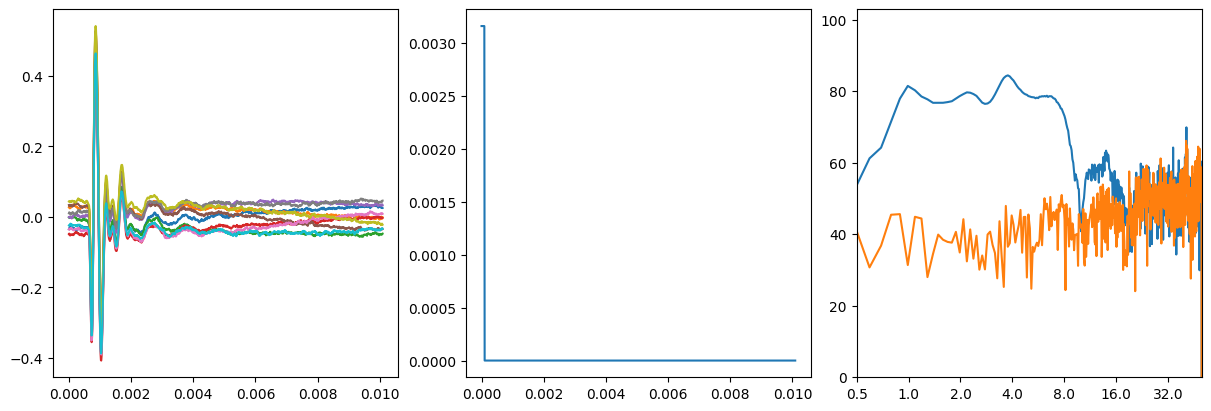

In [250]:
figure, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

recorded_waveform = result.attrs['waveforms'].loc['starship_A_microphone']
axes[0].plot(recorded_waveform.xs(gain, level='gain').T)
stimulus_waveform = result.attrs['stimulus']['starship_A_microphone']
axes[1].plot(stimulus_waveform)

axes[2].plot(result.attrs['SPL'].loc['starship_A_microphone', 'click_spl'])
axes[2].plot(result.attrs['SPL'].loc['starship_A_microphone', 'silence_spl'])
#axes[2].plot(util.db(recording.loc['starship_A_microphone', 'stimulus_rms']))
axes[2].set_xscale('octave')
axes[2].axis(xmin=0.5e3, xmax=50e3, ymin=0)

In [219]:
recording.groupby('channel')['click_spl'].apply(util.rms_rfft_db)

channel
starship_A_microphone    98.089249
Name: click_spl, dtype: float64

In [214]:
recording.query('(frequency >= 0)').groupby('channel')['click_spl'].apply(util.rms_rfft_db)

channel
starship_A_microphone    108.083012
Name: click_spl, dtype: float64

In [202]:
recording.groupby('channel')['silence_spl'].apply(util.rms_rfft_db)

channel
starship_A_microphone    71.390656
Name: silence_spl, dtype: float64

In [ ]:
util.rms_rfft_db(re

In [ ]:
result = []
for ai_channel, signal in recording.items():
    mean_signal = signal.groupby('gan').mean()
    
    samples = int(round(ai_channel.fs * (duration + iti)))
    factory = ClickFactory(ai_channel.fs, **factory_kw)
    chirp_waveform = factory.next(samples)

    chirp_psd = util.psd_df(chirp_waveform, ai_channel.fs)
    mean_psd = util.psd_df(mean_signal, ai_channel.fs)

    result[ai_channel.name] = pd.DataFrame({
        'rms': mean_psd.loc[gain],
        'chirp_rms': chirp_psd,
        'snr': util.db(mean_psd.loc[gain] / mean_psd.loc[-400]),
    })
    waveforms[ai_channel.name] = signal

    
    signal = signal.query('gain != -400')
    

    channel_result = []
    for (g, f), s in signal.groupby(['gain']):
        click_psd = util.psd_df(
        
        channel_result.append(f_result)

    df = pd.DataFrame(channel_result)
    df['channel_name'] = ai_channel.name
    df['input_channel_gain'] = ai_channel.gain
    result.append(df)

result = pd.concat(result).set_index(['channel_name', 'frequency'])
result.attrs['waveforms'] = signal
result.attrs['fs'] = {c.name: c.fs for c in recording}
return result


In [34]:
fixed_gain_result = tone.tone_sens(
    frequencies=frequencies,
    engine=audio_engine,
    ao_channel_name='speaker_1',
    ai_channel_names=['reference_microphone_channel', 'microphone_channel'],
    gains=-30,
    debug=True,
    duration=0.1,
    iti=0,
    trim=0.01,
    repetitions=2,
)

In [35]:
fixed_gain_result['norm_spl'].unstack('channel_name').eval('microphone_channel-reference_microphone_channel')

frequency
250.0     -3.214936
500.0     -0.928713
1000.0    -0.617545
2000.0    -0.597211
4000.0    -0.609537
8000.0    -0.608364
16000.0   -0.377281
32000.0   -0.231312
dtype: float64

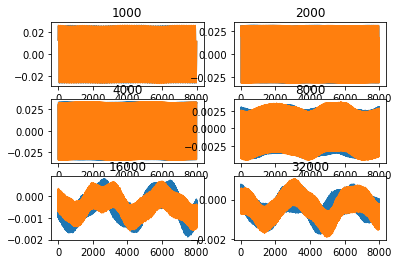

In [23]:
rms = fixed_gain_result.loc['reference_microphone_channel']['rms'].loc[1000]
figure, axes = pl.subplots(3, 2)

for ax, freq in zip(axes.ravel(), frequencies):
    w = fixed_gain_result.loc['microphone_channel', freq]['waveform'].T
    ax.plot(w)
    ax.set_title(freq)


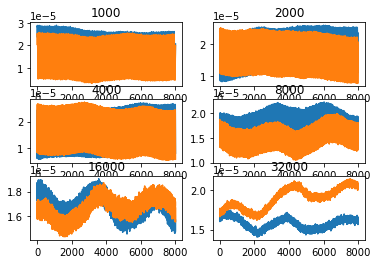

In [22]:
figure, axes = pl.subplots(3, 2)

for ax, freq in zip(axes.ravel(), frequencies):
    w = fixed_gain_result.loc['reference_microphone_channel', freq]['waveform'].T
    ax.plot(w)
    ax.set_title(freq)

In [6]:
tone_sens = fixed_gain_result.loc['microphone_channel', 'sens']
calibration = PointCalibration(tone_sens.index, tone_sens.values)
gains = calibration.get_gain(frequencies, 80)

In [7]:
variable_gain_result = tone.tone_spl(
    frequencies=frequencies,
    engine=audio_engine,
    ao_channel_name='speaker_1',
    ai_channel_names=['microphone_channel'],
    gains=gains,
    debug=True,
    duration=0.1,
    iti=0,
    trim=0.01,
    repetitions=2,
)

variable_gain_result['spl']

InvalidAttributeValueError: Requested value is not a supported value for this property. The property value may be invalid because it conflicts with another property.
Property: DAQmx_AO_Min
Requested Value: -2.034343e6
Maximum Value:  10.0
Minimum Value: -10.0
Channel Name: speaker_1

Task Name: NI_audio_hw_ao

Status Code: -200077
 in function DAQmxGetSampClkRate

In [ ]:
from psiaudio.stim import ChirpFactory

factory = ChirpFactory(fs=speaker_channel.fs,
                       start_frequency=500,
                       end_frequency=50000,
                       duration=0.02,
                       level=-40,
                       calibration=FlatCalibration.as_attenuation())

n = factory.n_samples_remaining()
chirp_waveform = factory.next(n)

result = util.acquire(audio_engine, chirp_waveform, 'speaker_1', ['microphone_channel'], repetitions=64, trim=0)

In [ ]:
chirp_response = result['microphone_channel'][0]
chirp_psd = psd_df(chirp_response, mic_channel.fs)
chirp_psd_mean = chirp_psd.mean(axis=0)
chirp_psd_mean_db = db(chirp_psd_mean)

signal_psd = db(psd_df(chirp_waveform, speaker_channel.fs))

freq = chirp_psd.columns.values
chirp_spl = mic_channel.calibration.get_spl(freq, chirp_psd)
chirp_spl_mean = chirp_spl.mean(axis=0)
chirp_sens = signal_psd - chirp_spl_mean - db(20e-6)

In [ ]:
chirp_sens.loc[1000]

In [ ]:
figure, axes = pl.subplots(1, 3, figsize=(12, 3))

chirp_response_mean = np.mean(chirp_response, axis=0)
print(chirp_response_mean.min(), chirp_response_mean.max())
axes[0].plot(chirp_response_mean)

freq = chirp_spl_mean.index.values
axes[1].semilogx(freq[1:], chirp_spl_mean[1:])
x = psd_df(chirp_response_mean, mic_channel.fs)
y = mic_channel.calibration.get_spl(x.index, x.values)
axes[1].semilogx(freq[1:], y[1:], 'r')
axes[1].axis(xmin=500, xmax=50000)

axes[2].semilogx(freq[1:], chirp_sens[1:])
axes[2].plot(tone_sens, 'ko')
axes[2].axis(xmin=500, xmax=50000)